# DATA INFO

Source of the data: 
https://www.kaggle.com/code/surekharamireddy/covid-19-rorschach-test-dataset/

Straight away, the dataset was used for a study about the evolution of Rorschach protocols before and after the Pandemic: "Perform between-subject statistical analysis (covariance & clustering) of all the sample variables, to detect changes between pre and post pandemic responses to the Rorschach test."

Some important information about the data: 

    User : User Id number
    PQlevel : Professional qualifications levels are based on the
    Clinet : Client Id number
    Age : Client age in Years
    Gender : Client Gender
    Country : Client Country
    Protocol : Protocol Id Number
    Test Date : The Date the RAP3 protocol was created
    R : The total number of the responses associated with the protocol
    ResponseOrder : The order of responses in the protocol
    CardId : Rorschach cardnumber 1 to 10
    Location : Indicated to which area of the blot the responses referred to
    LocationNumber : The location Normative Number
    Developmental Quality : The quality of processing that has been involved in the formation of the responses
    Determinants : All the visual stimulli in the blot that shaped the reported objects in the response .
    Pair : Two identical objects are reported , based on the symmetry of the blot
    Form Quality : Indicates how good is the fitness between the area of blot being used and the form requirements of the object specified in the response
    FQtext : The form quality associated Normative Text
    Contents : Content Coding is consisting of abbrevations for the category to which the responded object Belongs
    Popular : Responses that occur with a high frequency with a normative sample .
    ZCode : ZCode is coded in responses that involve organizational activity of relationships between distinct blot areas .
    ZScore : A Numerical value assigned to responses in which such Organizational activity occurs .
    Special Scores : Indicate the presence of special features in the response
    Rejection : The number of card rejections in the Protocol .


# Data exploration and cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [2]:
data = pd.read_csv(r"rap_dataset.tsv", sep = "\t")

In [3]:
data.isna().sum()

User                         0
PQLevel                      0
Client                       0
Age                          0
Gender                       0
Country                      0
Protocol                     0
TestDate                     0
R                            0
ResponseOrder                0
cardID                       0
Location                     0
LocationNumber          119435
DevelopmentalQuality         0
Determinants                 0
Pair                         0
FormQuality                  0
FQText                  442103
Contents                     0
Popular                      0
ZCode                   238068
ZScore                  238069
SpecialScores           298146
Rejection                    0
dtype: int64

In [4]:
df = data.dropna()

In [5]:
df.columns

Index(['User', 'PQLevel', 'Client', 'Age', 'Gender', 'Country', 'Protocol',
       'TestDate', 'R', 'ResponseOrder', 'cardID', 'Location',
       'LocationNumber', 'DevelopmentalQuality', 'Determinants', 'Pair',
       'FormQuality', 'FQText', 'Contents', 'Popular', 'ZCode', 'ZScore',
       'SpecialScores', 'Rejection'],
      dtype='object')

In [6]:
df.shape

(14351, 24)

In [7]:
df["FQText"].value_counts()

FQText
Human                                      825
Humans (Two with D7 as separate object)    696
Humans (Two)                               683
Human-Like Figure                          547
Humans or Human-Like Figures               547
                                          ... 
Branch                                       1
Head (Animal, large)                         1
Flesh                                        1
Doorframe                                    1
Shrimp (Two, natural form)                   1
Name: count, Length: 747, dtype: int64

As we can se above, there are many duplicate texts with the corresponding annotations. 

In [8]:
# Looking at the entries that have the same text and cardID

duplicate = df.duplicated(subset=["FQText", "cardID"])
df_same_response_same_card_diff_determinant = df[duplicate]
df_same_response_same_card_diff_determinant[["FQText","cardID", "Determinants", "Contents"]].sort_values("FQText")

,FQText,cardID,Determinants,Contents
398851,Abstract,7,Mp,"Hd,Hx"
259663,Abstract,7,Fr,"Art,A"
203209,Abstract,7,F,"Art,H"
401257,Abstract Drawing,6,"FMa,FD","Ad,A,Hd"
374178,Abstract Drawing,6,ma,Hx
...,...,...,...,...
473568,X-ray (Specific),6,"FD,C'F","Xy,Hd"
280932,X-ray (Unspecified),3,FC',"Hd,H"
145050,X-ray (Unspecified),3,FC',"Art,An"
145034,X-ray (Unspecified),3,"FT,C'","Xy,Hd"


And we also observe that the annotations are not consistent!

Ideally we would consult a psychologist or try to validate the dataset but for the sake of having a POC up and running, I will drop repeated responses.

Since we have a column that tells us the qualification level of the psychologist who evaluated the text, we'll order the texts alphabetically first and then we will order the text by the qualifications of the psychologist. This way, we'll get the texts with the most qualified psychologist first and we can drop duplicates while keeping the evaluations of "higher quality."

In [9]:
df_2 = df.sort_values("PQLevel", ascending=False).drop_duplicates(subset=["FQText"], keep="first")
df_2.shape

(747, 24)

We have dropped a lot of data points which is not ideal. Moreover, it may be helpful to use the cardID as a feature as we can see it is relevant by the amount of text whose label varies according to it. At a first glance, it seems obvious that the models we trained won't have satisfactory results given the low quality of the data but we'll proceed just to make a POC.

# Working with labels

In [10]:
labels = df_2[['Contents']]

In [11]:
len(df_2['Contents'].unique())

209

The explanation for the amount of unqiue labels is that there are different possible combinations of labels and they appear all together the the columns separated by commas.

In [12]:
counts = pd.DataFrame(labels.value_counts(), columns=["count"])
counts = counts[counts["count"] < 10]
counts

,count
Contents,
"H,Sc",9
(A),9
Fd,9
Cg,8
"Hd,An",8
...,...
"Ay,Bt,Hh",1
"Ay,Cg,Hd",1
"Ay,Fi",1


In [13]:
df_2['Contents'].iloc[30:50]

313203         Hd
313207      Hd,Xy
313234          H
320126          H
320597         Hd
320608    H,Hx,Hh
320612        (H)
325685        (A)
330258          A
330264         Ad
330292       (Hd)
330297         Ad
330313          A
330331    Ad,(Hd)
330503      Na,Ex
330508    (H),Art
325680         An
323718         An
320617      Sc,Ex
322179         Hd
Name: Contents, dtype: object

And that is the case for the determinants as well.

In [14]:
df_2[["Determinants"]]

,Determinants
121,Ma
313396,"FD,ma,FT"
313400,"FD,C"
313749,F
313760,Mp
...,...
433526,"FC,ma"
258760,ma-p
440801,"C',F"
324198,F


First we will translate the labels to the way they are written in the French version of the texts and then we will create dummies.

### Translating the labels to the French version of the test

In [15]:
import json

In [16]:
with open("translation_contents.json", "r") as f:
    translation_conts = json.load(f)
    
with open("translation_determinant.json", "r") as f:
    translation_dets = json.load(f)

There are some duplicate (upper and lowercase) determinants in the original dataset so we'll deal with those now as well.

In [17]:
translation_dets

{'FD': 'FE',
 'FMa': 'kan',
 'FMa-p': 'kan',
 'FMap': 'kan',
 'FMp': 'kan',
 'FT': 'FE',
 'FV': 'FE',
 'FY': 'FE',
 'Ma': 'K',
 'Ma-p': 'K',
 'Mp': 'K',
 'T': 'E',
 'TF': 'EF',
 'V': 'E',
 'VF': 'C',
 'Y': 'EF',
 'YF': 'E',
 'Fr': 'EF',
 'rF': 'F'}

In [18]:
translation_determinants = {} 

for k, v in translation_dets.items():
    translation_determinants[k] = v
    translation_determinants[str(k).lower()] = v # accounting for upper/lower case variants
    translation_determinants[str(k).upper()] = v  


In [19]:
translation_determinants

{'FD': 'FE',
 'fd': 'FE',
 'FMa': 'kan',
 'fma': 'kan',
 'FMA': 'kan',
 'FMa-p': 'kan',
 'fma-p': 'kan',
 'FMA-P': 'kan',
 'FMap': 'kan',
 'fmap': 'kan',
 'FMAP': 'kan',
 'FMp': 'kan',
 'fmp': 'kan',
 'FMP': 'kan',
 'FT': 'FE',
 'ft': 'FE',
 'FV': 'FE',
 'fv': 'FE',
 'FY': 'FE',
 'fy': 'FE',
 'Ma': 'K',
 'ma': 'K',
 'MA': 'K',
 'Ma-p': 'K',
 'ma-p': 'K',
 'MA-P': 'K',
 'Mp': 'K',
 'mp': 'K',
 'MP': 'K',
 'T': 'E',
 't': 'E',
 'TF': 'EF',
 'tf': 'EF',
 'V': 'E',
 'v': 'E',
 'VF': 'C',
 'vf': 'C',
 'Y': 'EF',
 'y': 'EF',
 'YF': 'E',
 'yf': 'E',
 'Fr': 'EF',
 'fr': 'EF',
 'FR': 'EF',
 'rF': 'F',
 'rf': 'F',
 'RF': 'F'}

In [20]:
translation_contents = {}

for k, v in translation_conts.items():
    translation_contents[k] = v
    translation_contents[str(k).lower()] = v # accounting for upper/lower case variants
    translation_contents[str(k).upper()] = v 


In [21]:
# translation_contents

In [22]:
labels = df_2[["Determinants"]]
labels

,Determinants
121,Ma
313396,"FD,ma,FT"
313400,"FD,C"
313749,F
313760,Mp
...,...
433526,"FC,ma"
258760,ma-p
440801,"C',F"
324198,F


In [23]:
def translate_df(text, translation_dict=translation_determinants):
    # print(text)
    list_tags = text.split(",")
    for k, v in translation_dict.items():
        if k in list_tags:
            list_tags.append(v)
            list_tags.remove(k)
    new_text = ",".join(list_tags)
    return new_text
    
labels["Determinants"] = labels["Determinants"].apply(translate_df)
# labels

C:\Users\alber\AppData\Local\Temp\ipykernel_13516\1758615046.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels["Determinants"] = labels["Determinants"].apply(translate_df)


In [24]:
labels_contents = df_2[["Contents"]]

In [25]:
def translate_df(text, translation_dict=translation_contents):
    # print(text)
    list_tags = text.split(",")
    for k, v in translation_dict.items():
        if k in list_tags:
            list_tags.append(v)
            list_tags.remove(k)
    new_text = ",".join(list_tags)
    return new_text
    
labels_contents["Contents"] = labels_contents["Contents"].apply(translate_df)
# labels_contents

C:\Users\alber\AppData\Local\Temp\ipykernel_13516\339835643.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_contents["Contents"] = labels_contents["Contents"].apply(translate_df)


# Determinant labels

In [26]:
labels_determinants = labels.apply(lambda labels: [x.split(",") for x in labels])
labels_determinants = labels_determinants['Determinants'].str.join('|').str.get_dummies()

In [27]:
labels_determinants

,C,C',C'F,CF,E,EF,F,FC,FC',FE,K,kan
121,0,0,0,0,0,0,0,0,0,0,1,0
313396,0,0,0,0,0,0,0,0,0,1,1,0
313400,1,0,0,0,0,0,0,0,0,1,0,0
313749,0,0,0,0,0,0,1,0,0,0,0,0
313760,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
433526,0,0,0,0,0,0,0,1,0,0,1,0
258760,0,0,0,0,0,0,0,0,0,0,1,0
440801,0,1,0,0,0,0,1,0,0,0,0,0
324198,0,0,0,0,0,0,1,0,0,0,0,0


In [28]:
agg_dict_determinants = {}
total = 0
for label in labels_determinants.columns:
    total_label = sum(labels_determinants[label])
    total = total + total_label
    agg_dict_determinants[label] = total_label
agg_dict_determinants["total"] = total
agg_dict_determinants

{'C': 15,
 "C'": 7,
 "C'F": 16,
 'CF': 46,
 'E': 19,
 'EF': 25,
 'F': 253,
 'FC': 70,
 "FC'": 40,
 'FE': 111,
 'K': 259,
 'kan': 114,
 'total': 975}

Now we can see the actual distribution of the labels in the data!

# Determinant Labels Distribution

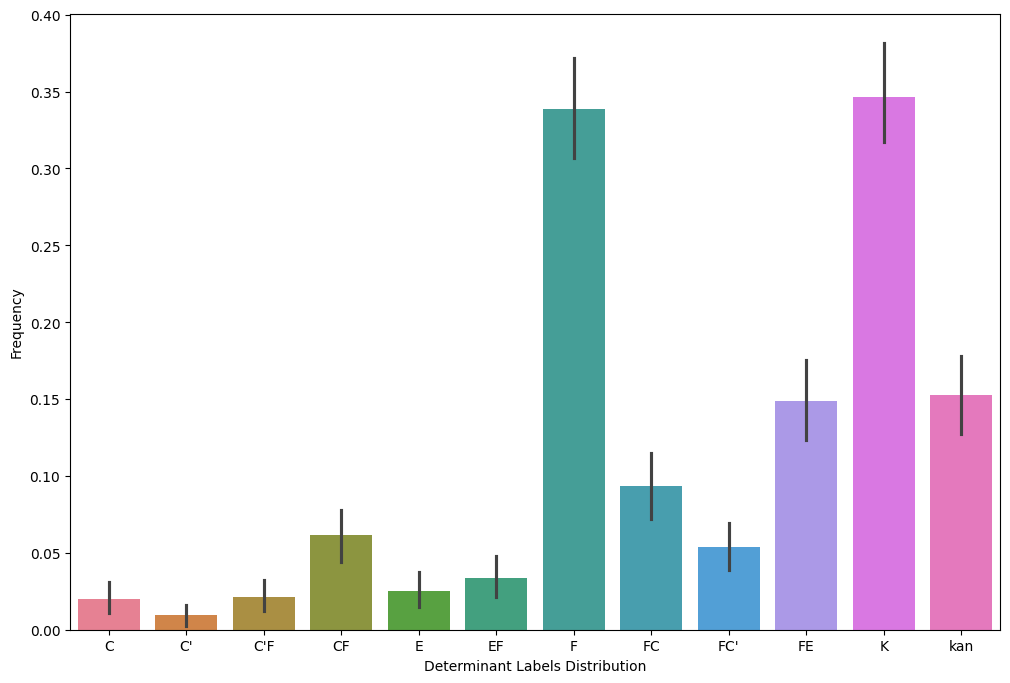

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=labels_determinants)
ax.set_xlabel("Determinant Labels Distribution")
ax.set_ylabel("Frequency")
plt.show()

<!-- We can see that there are barely any examples of the Cn label -->

In [30]:
# df_2[df_2["Determinants"].str.contains(",Cn")]

And we can also note that in 16/23 of the times it appears, the Cn label is accompanied by other label.

# Content labels

In [31]:
labels_contents

,Contents
121,A
313396,Nat
313400,Nat
313749,(Hd)
313760,H
...,...
433526,Bot
258760,"Hd,Sex"
440801,(Hd)
324198,"H,Vet"


In [32]:

labels_contents = labels_contents.apply(lambda labels: [x.split(",") for x in labels])
labels_contents = labels_contents['Contents'].str.join('|').str.get_dummies()


In [33]:
labels_contents

,(A),(Ad),(H),(Hd),A,Abs,Ad,Alim,Anat,Art,...,Hd,Id,Nat,Obj,Pays,Radio,Sc,Sex,Sg,Vet
121,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313396,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
313400,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
313749,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
258760,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
440801,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
agg_dict_contents = {}
total = 0
for label in labels_contents.columns:
    total_label = sum(labels_contents[label])
    total = total + total_label
    agg_dict_contents[label] = total_label
agg_dict_contents["total"] = total
agg_dict_contents

{'(A)': 19,
 '(Ad)': 13,
 '(H)': 69,
 '(Hd)': 35,
 'A': 165,
 'Abs': 29,
 'Ad': 64,
 'Alim': 19,
 'Anat': 52,
 'Art': 42,
 'Bot': 24,
 'Elem': 17,
 'Frag': 14,
 'Ge': 8,
 'H': 86,
 'Hd': 117,
 'Id': 12,
 'Nat': 51,
 'Obj': 57,
 'Pays': 37,
 'Radio': 8,
 'Sc': 79,
 'Sex': 13,
 'Sg': 13,
 'Vet': 68,
 'total': 1111}

# Content labels Distribution

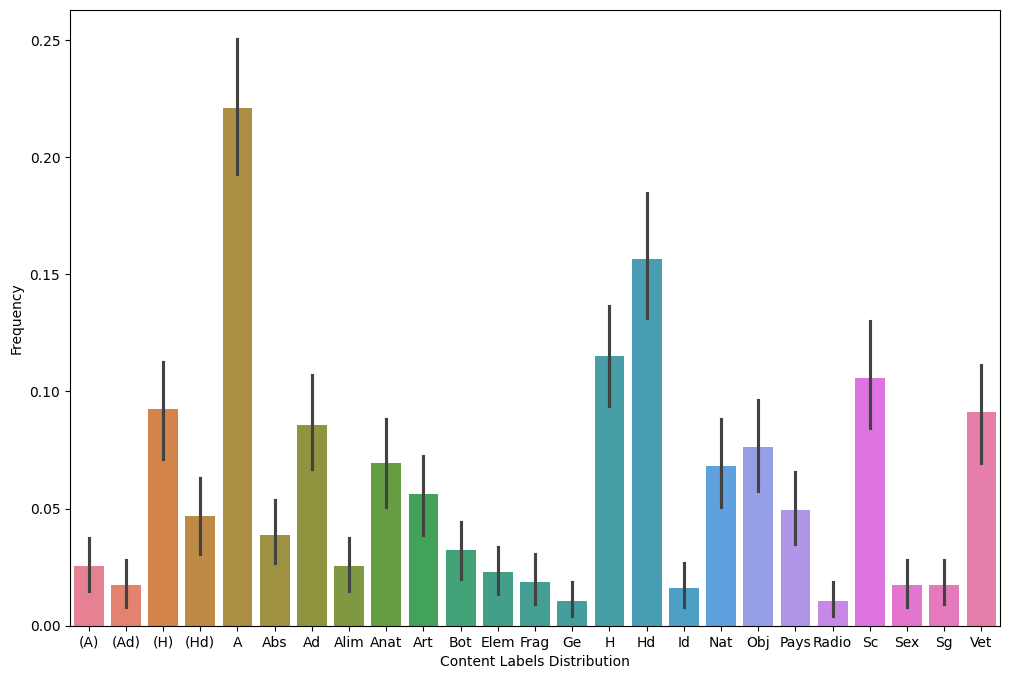

In [35]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=labels_contents)
ax.set_xlabel("Content Labels Distribution")
ax.set_ylabel("Frequency")
plt.show()

Since the names of the columns for the binary content / determinant labels are not intuitive at all, I'll save the columns in new variables. That way we will be able to get our y by indexing by the list of columns.

# Saving the data

In [36]:
cols_determinants = list(labels_determinants.columns)
cols_contents = list(labels_contents.columns)


In [37]:
X = df_2["FQText"].to_numpy()
y_determinants = labels_determinants.to_numpy()
y_contents = labels_contents.to_numpy()

In [38]:
data_clean_determinants = pd.concat([df_2["FQText"], labels_determinants], axis=1)
data_clean_determinants.to_csv("data_clean_determinants.csv", index=False)
data_clean_determinants

,FQText,C,C',C'F,CF,E,EF,F,FC,FC',FE,K,kan
121,Animal (Winged but unspecified),0,0,0,0,0,0,0,0,0,0,1,0
313396,Tree,0,0,0,0,0,0,0,0,0,1,1,0
313400,Lobster and Seaweed,1,0,0,0,0,0,0,0,0,1,0,0
313749,Eyes (Abstract),0,0,0,0,0,0,1,0,0,0,0,0
313760,Humans or Human-Like Figures (As D1 in a scene...,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
433526,Bud (Flower),0,0,0,0,0,0,0,1,0,0,1,0
258760,Breasts,0,0,0,0,0,0,0,0,0,0,1,0
440801,Clouds,0,1,0,0,0,0,1,0,0,0,0,0
324198,Ballerina (In costume),0,0,0,0,0,0,1,0,0,0,0,0


In [39]:
data_clean_contents = pd.concat([df_2["FQText"], labels_contents], axis=1)
data_clean_contents.to_csv("data_clean_contents.csv", index=False)
data_clean_contents

,FQText,(A),(Ad),(H),(Hd),A,Abs,Ad,Alim,Anat,...,Hd,Id,Nat,Obj,Pays,Radio,Sc,Sex,Sg,Vet
121,Animal (Winged but unspecified),0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313396,Tree,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
313400,Lobster and Seaweed,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
313749,Eyes (Abstract),0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313760,Humans or Human-Like Figures (As D1 in a scene...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433526,Bud (Flower),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
258760,Breasts,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
440801,Clouds,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324198,Ballerina (In costume),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [40]:
# X
# y_determinants
# y_contents
print(X.shape)
print(y_contents.shape)
print(y_determinants.shape)

(747,)
(747, 25)
(747, 12)
